In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
#from wordcloud import WordCloud

#Input data files are available in the read-only "../input/" directory
#For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [ ]:
pwd()

In [4]:
import pandas as pd

file_path = '/sfs/qumulo/qhome/cfm5qc/Documents/MSDS/DS6050/'  # Replace with your actual file path

# Load the data into a pandas DataFrame
df = pd.read_csv(f'{file_path}train.txt', sep=';', header=None, names=['content', 'sentiment'])
df2 = pd.read_csv(f'{file_path}val.txt', sep=';', header=None, names=['content', 'sentiment'])
df3 = pd.read_csv(f'{file_path}test.txt', sep=';', header=None, names=['content', 'sentiment'])
df = pd.concat([df,df2,df3])
# Strip any leading/trailing whitespace characters from the data
df['content'] = df['content'].str.strip()
df['sentiment'] = df['sentiment'].str.strip()

# Show the DataFrame
print(df.head())

                                             content sentiment
0                            i didnt feel humiliated   sadness
1  i can go from feeling so hopeless to so damned...   sadness
2   im grabbing a minute to post i feel greedy wrong     anger
3  i am ever feeling nostalgic about the fireplac...      love
4                               i am feeling grouchy     anger


In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

In [ ]:
df.duplicated().sum()

In [ ]:
df['sentiment'].value_counts()

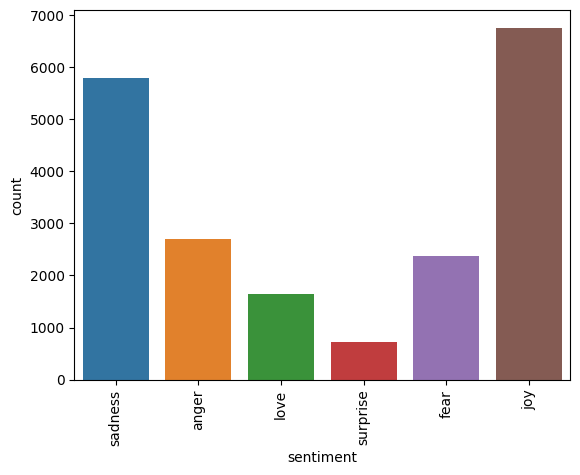

In [4]:
sns.countplot(x=df['sentiment'])
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.histplot(x=df['sentiment'], kde=True)
plt.xticks(rotation=90)
plt.show()

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/cfm5qc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/cfm5qc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cfm5qc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/cfm5qc/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

# Remove junk

In [7]:
def text_preprocessing_platform(df, text_col, remove_stopwords=True):
    
    ## Define functions for individual steps
    # First function is used to denoise text
    def denoise_text(text):
        # Strip html if any. For ex. removing <html>, <p> tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        # Replace contractions in the text. For ex. didn't -> did not
        text = contractions.fix(text)
        return text
    
    ## Next step is text-normalization
    
    # Text normalization includes many steps.
    
    # Each function below serves a step.
    
    
    def remove_non_ascii(words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words
    
    
    def to_lowercase(words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words
    
    
    def remove_punctuation(words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words
    
    
    def replace_numbers(words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words
    
    
    def remove_stopwords(words):
        """Remove stop words from list of tokenized words"""
        new_words = []
        for word in words:
            if word not in stopwords.words('english'):
                new_words.append(word)
        return new_words
    
    
    def stem_words(words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer()
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems
    
    
    def lemmatize_verbs(words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas
    
    
    ### A wrap-up function for normalization
    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words)
        words = to_lowercase(words)
        words = remove_punctuation(words)
        words = replace_numbers(words)
        if remove_stopwords:
            words = remove_stopwords(words)
        #words = stem_words(words)
        words = lemmatize_verbs(words)
        return words
    
    # All above functions work on word tokens we need a tokenizer
    
    # Tokenize tweet into words
    def tokenize(text):
        return nltk.word_tokenize(text)
    
    
    # A overall wrap-up function
    def text_prepare(text):
        text = denoise_text(text)
        text = ' '.join([x for x in normalize_text(tokenize(text), remove_stopwords)])
        return text
    
    # run every-step
    df[text_col] = [text_prepare(x) for x in df[text_col]]
    
    
    # return processed df
    return df

In [8]:
df = text_preprocessing_platform(df, 'content', remove_stopwords=True)

In [9]:
df.head()

,content,sentiment
0,feel humiliate,sadness
1,go feel hopeless damn hopeful around someone c...,sadness
2,grab minute post feel greedy wrong,anger
3,ever feel nostalgic fireplace know still property,love
4,feel grouchy,anger


In [10]:
df['sentiment'].value_counts()

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: sentiment, dtype: int64

In [ ]:
'''
def categorize_sentiment(row):
    if row['sentiment'] in ['sadness', 'anger', 'fear']:
        return 'Concerned'
    #elif row['sentiment'] in ['neutral']:  # Note: 'empty' appears again; check if this is correct.
    #    return 'Neutral'
    elif row['sentiment'] in ['joy', 'love', 'surprise']:
        return 'Not Concerned'
    #elif row['sentiment'] in ['neutral']:
       # return 'Neutral'
    else:
        return 'Undefined'  # Handle any cases that don't fit the above categories

# Apply the function along the rows of the DataFrame
df['category'] = df.apply(categorize_sentiment, axis=1)
'''

# Balance data

In [9]:
df.columns = ['content', 'category']
df = df.query("category != 'surprise'")

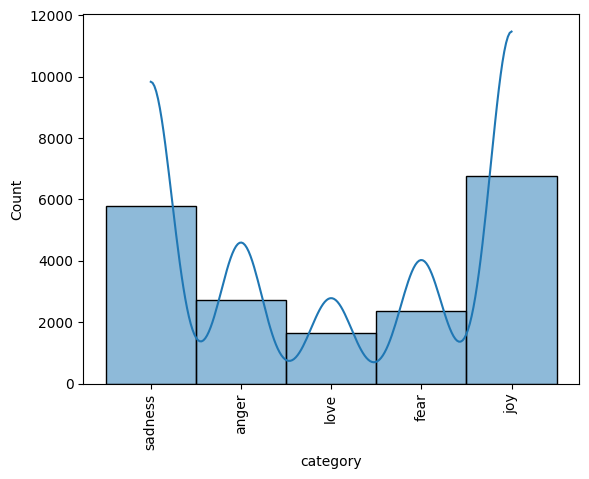

In [10]:
sns.histplot(x=df['category'], kde=True)
plt.xticks(rotation=90)
plt.show()

In [11]:
df['category'].value_counts()

joy        6761
sadness    5797
anger      2709
fear       2373
love       1641
Name: category, dtype: int64

In [12]:
label_mapping = {'joy':0, 'sadness':1, 'anger': 2, 'fear':3,'love':4}#, 'Concerned':2}, 'happiness': 2, 'sadness':3, 'love':4, 'surprise':5,'fun':6, 'relief':7, 'hate':8, 'empty':9,
              #  'enthusiasm':10, 'boredom':11,'anger':12}
df['category'] = df['category'].map(label_mapping)


In [13]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
print(f'Train: {len(train_df)}; Test: {len(test_df)}')

Train: 13496; Test: 5785


In [14]:
train_df

,content,category
10200,feel thankful everything life every day,0
1875,feel bite like franz liebkind producers many p...,0
50,stand finally stand feel like punish could go ...,1
14921,start feel unsure,3
11467,feel afraid live alone live far,3
...,...,...
11708,feel absolutely overwhelm,3
12417,would feel hesitant use medical system need,3
5623,feel love bless thank allah,4
902,funeral friend kill car accident age,1


In [15]:
X_train = train_df['content'].values
y_train = train_df['category'].values

X = test_df['content'].values
y = test_df['category'].values

X_test, X_valid, y_test, y_valid = train_test_split(X, y, test_size=0.25)

print(f'X_train: {len(X_train)}; X_test: {len(X_test)}; X_valid: {len(X_valid)}')
print(f'y_train: {len(y_train)}; y_test: {len(y_test)}; y_valid: {len(y_valid)}')

X_train: 13496; X_test: 4338; X_valid: 1447
y_train: 13496; y_test: 4338; y_valid: 1447


In [16]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()
y_valid = encoder.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
labels = np.unique(encoder.inverse_transform(y_train))

In [17]:
from transformers import XLNetForSequenceClassification
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import XLNetTokenizer
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import torch.nn as nn

In [18]:
# Define the RoBERTa model and tokenizer
model_name = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(model_name)
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=5)

# Tokenize and preprocess the text data
def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, padding=True, truncation=True)
    return tokens

train_df['TokenizedText'] = train_df['content'].apply(tokenize_text)
test_df['TokenizedText'] = test_df['content'].apply(tokenize_text)

# Convert tokenized data to PyTorch tensors with padding
X_train = pad_sequence([torch.tensor(seq) for seq in train_df['TokenizedText']], batch_first=True)
y_train = torch.tensor(train_df['category'].tolist())
X_test = pad_sequence([torch.tensor(seq) for seq in test_df['TokenizedText']], batch_first=True)
y_test = torch.tensor(test_df['category'].tolist())

# Define a DataLoader for batching data
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64)

# Define the training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for batch in tqdm(dataloader, desc="Training"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)  # Attention mask added by default
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [19]:
for epoch in range(10):  # Run for 10 epochs
    train_loss = train(model, train_dataloader, optimizer, criterion)
    print(f"Epoch {epoch+1}/{10}, Train Loss: {train_loss:.4f}")

# Evaluate the model on the test dataset
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.logits, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_true, y_pred, target_names=label_mapping.keys())
print("Classification Report:")
print(report)

Training: 100%|██████████| 211/211 [00:20<00:00, 10.27it/s]


Epoch 1/10, Train Loss: 1.0939


Training: 100%|██████████| 211/211 [00:18<00:00, 11.51it/s]


Epoch 2/10, Train Loss: 0.4343


Training: 100%|██████████| 211/211 [00:19<00:00, 11.02it/s]


Epoch 3/10, Train Loss: 0.2711


Training: 100%|██████████| 211/211 [00:21<00:00,  9.97it/s]


Epoch 4/10, Train Loss: 0.2001


Training: 100%|██████████| 211/211 [00:20<00:00, 10.31it/s]


Epoch 5/10, Train Loss: 0.1604


Training: 100%|██████████| 211/211 [00:18<00:00, 11.24it/s]


Epoch 6/10, Train Loss: 0.1398


Training: 100%|██████████| 211/211 [00:19<00:00, 10.81it/s]


Epoch 7/10, Train Loss: 0.1171


Training: 100%|██████████| 211/211 [00:20<00:00, 10.23it/s]


Epoch 8/10, Train Loss: 0.0977


Training: 100%|██████████| 211/211 [00:18<00:00, 11.15it/s]


Epoch 9/10, Train Loss: 0.0935


Training: 100%|██████████| 211/211 [00:20<00:00, 10.53it/s]


Epoch 10/10, Train Loss: 0.0815


Evaluating: 100%|██████████| 91/91 [00:02<00:00, 39.09it/s]

Confusion Matrix:
[[1934   35    9    9  103]
 [   6 1675   26   27    3]
 [   5   30  730   24    2]
 [   1   13   24  663    1]
 [  62    9    2    2  390]]
Classification Report:
              precision    recall  f1-score   support

         joy       0.96      0.93      0.94      2090
     sadness       0.95      0.96      0.96      1737
       anger       0.92      0.92      0.92       791
        fear       0.91      0.94      0.93       702
        love       0.78      0.84      0.81       465

    accuracy                           0.93      5785
   macro avg       0.91      0.92      0.91      5785
weighted avg       0.93      0.93      0.93      5785

